In [413]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from functions import *
from helpers import *
from proj1_helpers import *
from costs import *
from data_preprocessing import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("loading of the data : done")

loading of the data : done


## Data preprocessing

## Logistic Regression

In [231]:
from functions import logistic_regression_GD

def prediction(tx, w):
    y = tx @ w
    y[y > 0] = 1
    y[y <= 0] = 0
    return y

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

log_features = [1, 3, 4, 5, 8, 9, 13, 16, 19, 23, 26, 29]
normal_features = [0, 2, 6, 7, 10, 14, 17, 21, 24, 27]
uniform_feature = [15, 18, 20, 25, 28]
# two side are large
bernoulli_feature = [11, 12]
categorical_features = [22]

# Understand The Data

In [ ]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("loading of the data : done")

Basic

In [4]:
n_total_training_samples = tX.shape[0]
n_total_features         = tX.shape[1]

#### columns with missing values

In [423]:
columns_with_missing_values = []
for i in range(n_total_features):
    if -999 in tX[:, i]:
        columns_with_missing_values.append(i)

columns_with_missing_values

[0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]

In [359]:
log_features = [1, 3, 4, 5, 8, 9, 13, 16, 19, 23, 26, 29]
normal_features = [0, 2, 6, 7, 10, 14, 17, 21, 24, 27]
uniform_feature = [15, 18, 20, 25, 28]
# two side are large (perhaps beta distribution)
bernoulli_feature = [11, 12]
categorical_features = [22]

In [166]:
def split_data(x, y, ratio_of_training):
    """split the dataset based on the split ratio."""
    p = np.random.permutation(np.arange(y.shape[0]))
    n = int(y.shape[0] * ratio_of_training)
    return  x[p][:n], x[p][n:], y[p][:n], y[p][n:]

def prediction(tx, w):
    y = tx @ w
    y[y > 0] = 1
    y[y <= 0] = 0
    return y

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

In [392]:
def transform_y(y):
    tmp = y.copy()
    tmp[tmp == -1]=0
    return tmp

def transform_y_back(y):
    tmp = y.copy()
    tmp[tmp==0]=-1  
    return tmp

def prediction_and_accuracy(tr_tx, tr_y, te_tx, te_y, w):
    return accuracy(tr_y, prediction(tr_tx, w)), accuracy(te_y, prediction(te_tx, w))

# Preprocessing

#### fill missing values with their means.

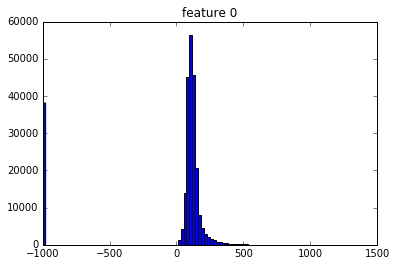

In [634]:
# Time Visualization
from ipywidgets import IntSlider, interact
from IPython.display import display

def fill_na(tx=tX, method=np.mean):
    filled = tx.copy()
    for col in columns_with_missing_values:
        tmp = filled[:, col]
        tmp[tmp == -999] = method(tmp[tmp != -999])
        filled[:, col] = tmp
    return filled

def plot_hist(tx, i, transformation=None):
    plt.figure()
    if transformation is None:
        plt.hist(tx[:, i], bins=100)
    else:
        plt.hist(transformation(tx[:, i]), bins=100)
    plt.title("feature %i" % i)
    plt.show()
    
# before processing 
interactive(lambda x:plot_hist(tX, x), x=IntSlider(min=0, max=29))

#### Expand features to reduce bias

In [133]:
def build_polynomial_without_mixed_term(tx, degree=2):
    n = tx.shape[0]
    tmp = tx
    for i in range(2, degree+1):
        tmp = np.c_[tmp, tx**i]
    # The function standardize will add a column of 1s in the first column
    return tmp

build_polynomial_without_mixed_term(np.arange(10).reshape(5,2), 3)

array([[  0,   1,   0,   1,   0,   1],
       [  2,   3,   4,   9,   8,  27],
       [  4,   5,  16,  25,  64, 125],
       [  6,   7,  36,  49, 216, 343],
       [  8,   9,  64,  81, 512, 729]])

## Classifier 1

specifications
    - polynomial of degree 2
    - didin't apply log to some features
    - validation (not cross validation)

fill -999 with mean/median/...

In [119]:
filled_tX = fill_na()

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_tX[filled_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

Here is the data used for interactive data analysis.

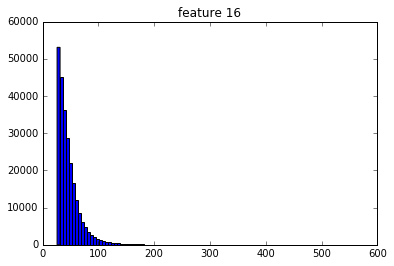

In [122]:
interactive(lambda x:plot_hist(filled_tX, x), x=IntSlider(value=1, min=0, max=n_total_features-1))

In [117]:
# some of the data is not allowed to perform log
def plot_function(idx):
    if idx in columns_non_negative:
        plot_hist(filled_tX, idx, lambda y: np.log(y+1e-6))
    else:
        pass
    
interactive(plot_function, idx=IntSlider(value=1, min=0, max=n_total_features-1))

#### standardize the columns

In [136]:
tmp = build_polynomial_without_mixed_term(filled_tX, degree = 2)
## We can take logs of each column Here *******************************
tX1, mean_x1, std_x1 = standardize(tmp)
y1 = transform_y(y)
tX1.shape

(250000, 61)

### sepearte training sets and cross validation sets and Predict w

In [546]:
training_ratio = 0.9
train_tX1, cv_tX1, train_y1, cv_y1 = split_data(tX1, y1, training_ratio)
cv_tX1.shape

(25000, 61)

In [547]:
plot_info = np.array(info)
sizes = plot_info[:, 2]
tr_error = plot_info[:, 0]
te_error = plot_info[:, 1]

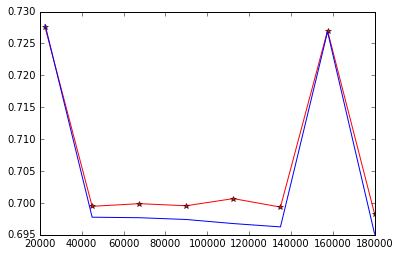

In [548]:
plt.plot(sizes, tr_error, 'r*-', sizes, te_error, 'b-')
plt.show()

## For how large the size, we can train it very accurately

gamma=0.1
lambda=0.01

|training size|iteration| acc train| acc test|
|:--:|:---:|:---:|
|100|1000| 0.98|0.70|
|150|1000|0.88|0.7|
|150|5000|0.93|0.71|
|150|10000|0.96|0.72464|
|150|20000|0.947|0.707|
|150|20000|0.953333333333| 0.70664|
|200|10000|0.885| 0.70876|
|10000|1000|0.6934| 0.69128|

we can see that with the grow of training size, the same classifier performs bad on traing set very quickly. For the same training sets, the grows of iterations can improve training performance, but can hardly influence test error.

Our model suffers from bias.

In [554]:
idxes = np.arange(200)
w, losses = reg_logistic_regression_GD(train_y1[idxes], train_tX1[idxes], gamma=0.001, 
                       max_iters = 2000, lambda_=0, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX1[idxes], train_y1[idxes], cv_tX1, cv_y1, w)
print(tr_acc, te_acc)

Losgistic Regression(0/2000): loss=-4257.306958500683
Losgistic Regression(1000/2000): loss=-16823.984342794996
0.845 0.73416


We see that the (original) feature 2, 4, 15, 18 has small feature in in it self, but their square can be large

# Classfier 2: Higher Order Polynomial

In [356]:
filled_tX = fill_na()

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_tX[filled_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

#### standardize the columns

In [253]:
tmp = build_polynomial_without_mixed_term(filled_tX, degree = 3)
## We can take logs of each column Here *******************************
tX2, mean_x2, std_x2 = standardize(tmp)
y2 = transform_y(y)
tX2.shape

(250000, 91)

### sepearte training sets and cross validation sets and Predict w

In [260]:
training_ratio = 0.9
train_tX2, cv_tX2, train_y2, cv_y2 = split_data(tX2, y2, training_ratio)
cv_tX2.shape

(25000, 91)

In [357]:
idxes = np.arange(5000)
L=np.linalg.eigvals(train_tX2[idxes].T @ train_tX2[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y2[idxes], train_tX2[idxes], gamma=1/L, 
                       max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX2[idxes], train_y2[idxes], cv_tX2, cv_y2, w)
print(tr_acc, te_acc)

1.31858812606e-05
Losgistic Regression(0/100000): loss=-1576381.4131746194
Losgistic Regression(1000/100000): loss=-2609588.730715125
Losgistic Regression(2000/100000): loss=-3167813.2138219867
Losgistic Regression(3000/100000): loss=-3472116.763273852
Losgistic Regression(4000/100000): loss=-3685713.505443715
Losgistic Regression(5000/100000): loss=-3849144.4587358832
Losgistic Regression(6000/100000): loss=-3981252.780542511
Losgistic Regression(7000/100000): loss=-4091986.6941092336
Losgistic Regression(8000/100000): loss=-4187103.3739277883
Losgistic Regression(9000/100000): loss=-4270247.950210498
Losgistic Regression(10000/100000): loss=-4343888.490349865
Losgistic Regression(11000/100000): loss=-4409771.966527175
Losgistic Regression(12000/100000): loss=-4469173.647771348
Losgistic Regression(13000/100000): loss=-4523053.768381426
Losgistic Regression(14000/100000): loss=-4572165.075756724
Losgistic Regression(15000/100000): loss=-4617120.198719306
Losgistic Regression(16000/100

In [364]:
idxes = np.arange(10000)
L=np.linalg.eigvals(train_tX2[idxes].T @ train_tX2[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y2[idxes], train_tX2[idxes], gamma=1/L, 
                       max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX2[idxes], train_y2[idxes], cv_tX2, cv_y2, w)
print(tr_acc, te_acc)

6.6932772662e-06
Losgistic Regression(0/100000): loss=434457.21842224855
Losgistic Regression(1000/100000): loss=-10234622.776920963
Losgistic Regression(2000/100000): loss=-12230873.927219868
Losgistic Regression(3000/100000): loss=-13370184.385959959
Losgistic Regression(4000/100000): loss=-14177368.686676051
Losgistic Regression(5000/100000): loss=-14804224.395295477
Losgistic Regression(6000/100000): loss=-15313039.706620015
Losgistic Regression(7000/100000): loss=-15737437.263241317
Losgistic Regression(8000/100000): loss=-16098504.39866479
Losgistic Regression(9000/100000): loss=-16410311.024095053
Losgistic Regression(10000/100000): loss=-16682700.350381702
Losgistic Regression(11000/100000): loss=-16922849.827691004
Losgistic Regression(12000/100000): loss=-17136175.98913687
Losgistic Regression(13000/100000): loss=-17326879.368117437
Losgistic Regression(14000/100000): loss=-17498293.407778494
Losgistic Regression(15000/100000): loss=-17653107.48084559
Losgistic Regression(160

In [330]:
np.arange(91)[abs(w)>1]%30

array([ 0,  7, 10, 13, 16,  0,  2,  8,  9, 13, 19,  0,  1,  3,  9, 13, 19,
        0])

# Classifier 3

In [467]:
def build_polynomial_without_mixed_term_with_log(tx, log_cols, degree=2):
    n = tx.shape[0]
    tmp = tx
    for i in range(2, degree+1):
        tmp = np.c_[tmp, tx**i]
        
    tmp = np.c_[tmp, np.log(tx[:, log_cols] + 1e-6)]
    tmp = np.c_[tmp, (np.log(tx[:, log_cols] + 1e-6))**2]
    tmp = np.c_[tmp, (np.log(tx[:, log_cols] + 1e-6))**3]
    return tmp

build_polynomial_without_mixed_term_with_log(np.arange(10).reshape(5,2), [1], 2)

array([[  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   9.99999500e-07,   9.99999000e-13,
          9.99998500e-19],
       [  2.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          9.00000000e+00,   1.09861262e+00,   1.20694969e+00,
          1.32597017e+00],
       [  4.00000000e+00,   5.00000000e+00,   1.60000000e+01,
          2.50000000e+01,   1.60943811e+00,   2.59029104e+00,
          4.16891312e+00],
       [  6.00000000e+00,   7.00000000e+00,   3.60000000e+01,
          4.90000000e+01,   1.94591029e+00,   3.78656686e+00,
          7.36831943e+00],
       [  8.00000000e+00,   9.00000000e+00,   6.40000000e+01,
          8.10000000e+01,   2.19722469e+00,   4.82779633e+00,
          1.06077533e+01]])

In [382]:
tmp = build_polynomial_without_mixed_term_with_log(filled_tX, log_features, degree = 4)
tX3, mean_x3, std_x3 = standardize(tmp)
y3 = transform_y(y)
tX3.shape

(250000, 133)

In [383]:
training_ratio = 0.9
train_tX3, cv_tX3, train_y3, cv_y3 = split_data(tX3, y3, training_ratio)
cv_tX3.shape

(25000, 133)

In [394]:
idxes = np.arange(5000)
L=np.linalg.eigvals(train_tX3[idxes].T @ train_tX3[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y3[idxes], train_tX3[idxes], gamma=0.0001, 
                       max_iters = 10000, lambda_=0.00, regularizor=regularizor_ridge)

tr_acc, te_acc = prediction_and_accuracy(train_tX3[idxes], train_y3[idxes], cv_tX3, cv_y3, w)
print(tr_acc, te_acc)

1.18430305201e-05
Losgistic Regression(0/10000): loss=-2611163.012880917
Losgistic Regression(1000/10000): loss=-3936990.4564067796
Losgistic Regression(2000/10000): loss=-4313944.990193981
Losgistic Regression(3000/10000): loss=-4530935.028052804
Losgistic Regression(4000/10000): loss=-4686759.265161883
Losgistic Regression(5000/10000): loss=-4806968.908878522
Losgistic Regression(6000/10000): loss=-4904122.84751413
Losgistic Regression(7000/10000): loss=-4985372.565744881
Losgistic Regression(8000/10000): loss=-5055214.850281095
Losgistic Regression(9000/10000): loss=-5116816.102477511
0.813 0.80572


## For higher dimensions

In [399]:
tmp = build_polynomial_without_mixed_term_with_log(filled_tX, log_features, degree = 3)
tX4, mean_x4, std_x4 = standardize(tmp)
y4 = transform_y(y)
tX4.shape

(250000, 115)

In [400]:
training_ratio = 0.9
train_tX4, cv_tX4, train_y4, cv_y4 = split_data(tX4, y4, training_ratio)
cv_tX4.shape

(25000, 115)

In [440]:
idxes = np.arange(200)
L=np.linalg.eigvals(train_tX4[idxes].T @ train_tX4[idxes]).max()
print(1/L)

w = np.random.randn(train_tX4.shape[1]) * 0.1
maximum_size = train_y4.shape[0]

for i in range(10):
    idxes = np.random.randint(0, maximum_size, 2000)
    w, losses = reg_logistic_regression_SGD(train_y4[idxes], train_tX4[idxes], gamma=1/L, 
                       max_iters = 10000, lambda_=0.0001, regularizor=regularizor_lasso, w0=w)

    tr_acc, te_acc = prediction_and_accuracy(train_tX4[idxes], train_y4[idxes], cv_tX4, cv_y4, w)
    print(tr_acc, te_acc)

0.00025368797602
Losgistic Regression(0/10000): loss=-893711.0623600627
Losgistic Regression(1000/10000): loss=-944014.4622320133
Losgistic Regression(2000/10000): loss=-1033972.7961426789
Losgistic Regression(3000/10000): loss=-1083628.4283881453
Losgistic Regression(4000/10000): loss=-1114844.76407547
Losgistic Regression(5000/10000): loss=-1136101.0571259223
Losgistic Regression(6000/10000): loss=-1151420.8972547455
Losgistic Regression(7000/10000): loss=-1162947.157179648
Losgistic Regression(8000/10000): loss=-1171919.5317238276
Losgistic Regression(9000/10000): loss=-1179101.937071516
0.83 0.80236
Losgistic Regression(0/10000): loss=-888225.356995657
Losgistic Regression(1000/10000): loss=-914899.2770507383
Losgistic Regression(2000/10000): loss=-951666.3112675188
Losgistic Regression(3000/10000): loss=-972020.5028958153
Losgistic Regression(4000/10000): loss=-986281.9179660012
Losgistic Regression(5000/10000): loss=-997211.5103137465
Losgistic Regression(6000/10000): loss=-10060

In [442]:
tr_acc, te_acc = prediction_and_accuracy(train_tX4[idxes], train_y4[idxes], cv_tX4, cv_y4, w)
print(tr_acc, te_acc)

0.8205 0.80228


## For Higher Dimensions

In [585]:
tmp = build_polynomial_without_mixed_term_with_log(filled_tX, log_features, degree = 5)
tX5, mean_x5, std_x5 = standardize(tmp)
y5 = transform_y(y)
tX5.shape

(250000, 187)

In [645]:
training_ratio = 0.9
train_tX5, cv_tX5, train_y5, cv_y5 = split_data(tX5, y5, training_ratio)
cv_tX5.shape

(25000, 187)

In [646]:
idxes = np.arange(2000)
L = np.linalg.eigvals(train_tX5[idxes].T @ train_tX5[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y5[idxes], train_tX5[idxes], gamma=1/L, 
                   max_iters = 20000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX5[idxes], train_y5[idxes], cv_tX5, cv_y5, w)
print(tr_acc, te_acc)

2.23143465589e-05
Losgistic Regression(0/20000): loss=-152948.4985915193
Losgistic Regression(1000/20000): loss=-558222.8949306096
Losgistic Regression(2000/20000): loss=-641129.1642222997
Losgistic Regression(3000/20000): loss=-694583.4965614841
Losgistic Regression(4000/20000): loss=-733162.1216511249
Losgistic Regression(5000/20000): loss=-763211.2116422988
Losgistic Regression(6000/20000): loss=-787804.3128164957
Losgistic Regression(7000/20000): loss=-808619.5440130396
Losgistic Regression(8000/20000): loss=-826656.972967146
Losgistic Regression(9000/20000): loss=-842556.2018722652
Losgistic Regression(10000/20000): loss=-856751.7948597504
Losgistic Regression(11000/20000): loss=-869553.7814276543
Losgistic Regression(12000/20000): loss=-881193.2501136299
Losgistic Regression(13000/20000): loss=-891847.882410691
Losgistic Regression(14000/20000): loss=-901657.8873610676
Losgistic Regression(15000/20000): loss=-910736.4680695792
Losgistic Regression(16000/20000): loss=-919176.28158

## If we only use those features not missing

It will lose important information

In [647]:
no_missing_featuers = [i for i in range(30) if i not in columns_with_missing_values]

In [648]:
tmp = build_polynomial_without_mixed_term(tX[:, no_missing_featuers], degree = 3)
tX6, mean_x6, std_x6 = standardize(tmp)
y6 = transform_y(y)
tX6.shape

(250000, 58)

In [649]:
training_ratio = 0.9
train_tX6, cv_tX6, train_y6, cv_y6 = split_data(tX6, y6, training_ratio)
cv_tX6.shape

(25000, 58)

In [652]:
idxes = np.arange(5000)
L = np.linalg.eigvals(train_tX6[idxes].T @ train_tX6[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y6[idxes], train_tX6[idxes], gamma=1/L, 
                   max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX6[idxes], train_y6[idxes], cv_tX6, cv_y6, w)
print(tr_acc, te_acc)

9.5626812771e-05
Losgistic Regression(0/10000): loss=56635.91876811694
Losgistic Regression(1000/10000): loss=-70010.60927836965
Losgistic Regression(2000/10000): loss=-85440.47538549885
Losgistic Regression(3000/10000): loss=-94429.26704526579
Losgistic Regression(4000/10000): loss=-100765.83908769637
Losgistic Regression(5000/10000): loss=-105695.19605704182
Losgistic Regression(6000/10000): loss=-109808.0258851113
Losgistic Regression(7000/10000): loss=-113411.64391236744
Losgistic Regression(8000/10000): loss=-116671.54858691993
Losgistic Regression(9000/10000): loss=-119669.28184539902
0.798 0.76268


# Only derived

In [491]:
no_missing_featuers = [i for i in range(30) if i not in columns_with_missing_values]

In [506]:
tmp = build_polynomial_without_mixed_term(tX[:, 0:12], degree = 5)
tX7, mean_x7, std_x7 = standardize(tmp)
y7 = transform_y(y)
tX7.shape

(250000, 61)

In [507]:
training_ratio = 0.9
train_tX7, cv_tX7, train_y7, cv_y7 = split_data(tX7, y7, training_ratio)
cv_tX7.shape

(25000, 61)

In [508]:
idxes = np.arange(5000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=1/L, 
                   max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

1.366584075e-05
Losgistic Regression(0/100000): loss=80551.96217051383
Losgistic Regression(1000/100000): loss=-630513.4147324018
Losgistic Regression(2000/100000): loss=-795592.0324176315
Losgistic Regression(3000/100000): loss=-774859.9636654159
Losgistic Regression(4000/100000): loss=-903662.8565081253
Losgistic Regression(5000/100000): loss=-996484.1774392383
Losgistic Regression(6000/100000): loss=-1067880.9798726423
Losgistic Regression(7000/100000): loss=-1128515.1268494313
Losgistic Regression(8000/100000): loss=-1182350.0825128625
Losgistic Regression(9000/100000): loss=-1231311.037993663
Losgistic Regression(10000/100000): loss=-1276433.9699305983
Losgistic Regression(11000/100000): loss=-1318312.417875254
Losgistic Regression(12000/100000): loss=-1357323.755029252
Losgistic Regression(13000/100000): loss=-1393752.8738484322
Losgistic Regression(14000/100000): loss=-1427857.195925385
Losgistic Regression(15000/100000): loss=-1459893.3792936816
Losgistic Regression(16000/10000

# Better results

In [698]:
no_missing_featuers = [i for i in range(30) if i not in columns_with_missing_values]

In [655]:
tX[status_tX==7, columns_with_missing_values]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (69982,) (11,) 

In [658]:
status_tX =np.sum(tX == -999, axis=1)

In [659]:
non_missing_tX = tX[status_tX == 0, :]
missing_tX = tX[status_tX != 0, :]

In [669]:
tmp = build_polynomial_without_mixed_term(fill_na(tX, np.median), degree=4)
tX7, mean_x7, std_x7 = standardize(tmp)
y7 = transform_y(y)
tX7.shape

(250000, 121)

In [670]:
training_ratio = 0.9
train_tX7, cv_tX7, train_y7, cv_y7 = split_data(tX7, y7, training_ratio)
cv_tX7.shape

(25000, 121)

In [678]:
idxes = np.arange(5000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=0.0001, 
                   max_iters = 100000, lambda_=0.00001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

1.29134200029e-05
Losgistic Regression(0/100000): loss=-1717512.0003571624
Losgistic Regression(1000/100000): loss=-3648780.826639854
Losgistic Regression(2000/100000): loss=-4081218.460205971
Losgistic Regression(3000/100000): loss=-4294065.902958807
Losgistic Regression(4000/100000): loss=-4428942.877889703
Losgistic Regression(5000/100000): loss=-4526784.783047925
Losgistic Regression(6000/100000): loss=-4603639.278624557
Losgistic Regression(7000/100000): loss=-4667203.4450635025
Losgistic Regression(8000/100000): loss=-4721732.211992899
Losgistic Regression(9000/100000): loss=-4769965.168966695
Losgistic Regression(10000/100000): loss=-4814218.630067779
Losgistic Regression(11000/100000): loss=-4856063.867183341
Losgistic Regression(12000/100000): loss=-4895444.936642361
Losgistic Regression(13000/100000): loss=-4931965.253089373
Losgistic Regression(14000/100000): loss=-4965607.549755028
Losgistic Regression(15000/100000): loss=-4996576.564565537
Losgistic Regression(16000/100000

In [686]:
idxes = np.arange(10000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=0.0001, 
                   max_iters = 150000, lambda_=0.00001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

6.37656429545e-06
Losgistic Regression(0/150000): loss=-15963144.592339689
Losgistic Regression(1000/150000): loss=-16667671.693541316
Losgistic Regression(2000/150000): loss=-17212372.60830468
Losgistic Regression(3000/150000): loss=-17408288.015940994
Losgistic Regression(4000/150000): loss=-17499791.72486209
Losgistic Regression(5000/150000): loss=-17548372.77054372
Losgistic Regression(6000/150000): loss=-17424324.785498414
Losgistic Regression(7000/150000): loss=-17536282.58854017
Losgistic Regression(8000/150000): loss=-17665225.62948474
Losgistic Regression(9000/150000): loss=-17771234.220502492
Losgistic Regression(10000/150000): loss=-17862328.549905375
Losgistic Regression(11000/150000): loss=-17943540.53694835
Losgistic Regression(12000/150000): loss=-18018073.32970965
Losgistic Regression(13000/150000): loss=-18087990.19267849
Losgistic Regression(14000/150000): loss=-18154630.56449576
Losgistic Regression(15000/150000): loss=-18218867.233228095
Losgistic Regression(16000/1

In [704]:
idxes = np.arange(10000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=1/L, 
                   max_iters = 200000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

6.37656429545e-06
Losgistic Regression(0/200000): loss=9221233.193410587
Losgistic Regression(1000/200000): loss=-8296709.870189696
Losgistic Regression(2000/200000): loss=-9862373.335854245
Losgistic Regression(3000/200000): loss=-10831655.627667965
Losgistic Regression(4000/200000): loss=-11536115.326674325
Losgistic Regression(5000/200000): loss=-12075983.19691701
Losgistic Regression(6000/200000): loss=-12511679.921146508
Losgistic Regression(7000/200000): loss=-12874634.530713344
Losgistic Regression(8000/200000): loss=-13183781.813886058
Losgistic Regression(9000/200000): loss=-13451475.683294827
Losgistic Regression(10000/200000): loss=-13686264.729243582
Losgistic Regression(11000/200000): loss=-13894353.282241577
Losgistic Regression(12000/200000): loss=-14080409.165111527
Losgistic Regression(13000/200000): loss=-14248028.215456463
Losgistic Regression(14000/200000): loss=-14400034.902295291
Losgistic Regression(15000/200000): loss=-14538685.367201654
Losgistic Regression(160

In [749]:
idxes = np.arange(5000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=1/L, 
               max_iters = 500000, lambda_= 1e-6, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(i, tr_acc, te_acc)

1.29134200029e-05
Losgistic Regression(0/500000): loss=723067.1099047789
Losgistic Regression(1000/500000): loss=-2180644.3801299524
Losgistic Regression(2000/500000): loss=-2683202.9590092166
Losgistic Regression(3000/500000): loss=-2967470.1614839495
Losgistic Regression(4000/500000): loss=-3169324.4327838887
Losgistic Regression(5000/500000): loss=-3326573.8785344507
Losgistic Regression(6000/500000): loss=-3454658.275956527
Losgistic Regression(7000/500000): loss=-3561873.782498788
Losgistic Regression(8000/500000): loss=-3653327.650025917
Losgistic Regression(9000/500000): loss=-3732460.9580051103
Losgistic Regression(10000/500000): loss=-3801728.694845286
Losgistic Regression(11000/500000): loss=-3862951.477844607
Losgistic Regression(12000/500000): loss=-3917519.0733853476
Losgistic Regression(13000/500000): loss=-3966516.5337259974
Losgistic Regression(14000/500000): loss=-4010806.198426675
Losgistic Regression(15000/500000): loss=-4051083.1900321273
Losgistic Regression(16000/

In [719]:
correlation_list = []
for i in range(len(w)-1):
    correlation_list.append(np.corrcoef(train_y7, train_tX7[:, i])[0, 1])

In [722]:
c = np.array(correlation_list)

array([  2.65129855e-02,  -3.51612919e-01,  -1.38712350e-02,
         1.91876052e-01,   2.03718015e-01,   2.13023438e-01,
        -1.83174366e-01,   1.31601540e-02,  -1.51333685e-02,
         1.52662286e-01,  -1.96198138e-01,   2.72353631e-01,
         1.75387841e-01,   2.34864606e-01,  -2.94158012e-04,
        -4.79748618e-03,  -3.29888084e-02,   2.48140191e-03,
         4.86870767e-03,   2.12883597e-02,   5.62790946e-03,
         1.35090525e-01,   1.33094440e-01,   1.15036848e-01,
        -2.56697681e-04,   1.39365659e-03,   2.32211127e-02,
         1.37242072e-03,  -4.50596689e-03,   1.33843107e-01,
        -4.22503370e-02,  -2.09894679e-01,  -6.31467775e-02,
         1.06434966e-01,   2.33094856e-01,   1.75096532e-01,
         1.81317012e-01,  -1.37815655e-02,   2.06173286e-03,
         8.84978519e-02,  -1.00459724e-01,   4.62967153e-02,
         2.13143137e-01,   1.26363568e-01,  -1.12019572e-01,
        -1.44671666e-03,  -1.92796971e-02,  -1.46377790e-01,
        -2.47121748e-03,

In [728]:
np.arange(len(c))[abs(c) < 0.01]

array([ 14,  15,  17,  18,  20,  24,  25,  27,  28,  38,  45,  48,  50,
        56,  68,  74,  75,  76,  77,  78,  79,  80,  84,  85,  86,  87,
        88,  89,  93,  98, 103, 105, 106, 108, 109, 110, 116, 119])

In [730]:
np.arange(len(w))[abs(w) < 0.1]

array([  2,   6,   9,  11,  14,  15,  20,  24,  25,  27,  36,  41,  47,
        48,  50,  55,  56,  68,  72,  74,  75,  77,  80,  82,  84,  85,
        87, 101, 104, 108, 110, 115, 117])

## Best Results ever

In [ ]:
idxes = np.arange(10000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=0.0001, 
                   max_iters = 150000, lambda_=0.00001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

# test

In [750]:
no_missing_featuers = [i for i in range(30) if i not in columns_with_missing_values]

In [658]:
status_tX =np.sum(tX == -999, axis=1)

In [659]:
non_missing_tX = tX[status_tX == 0, :]
missing_tX = tX[status_tX != 0, :]

In [751]:
tmp = build_polynomial_without_mixed_term(fill_na(tX, np.median), degree=10)
tX7, mean_x7, std_x7 = standardize(tmp)
y7 = transform_y(y)
tX7.shape

(250000, 301)

In [759]:
training_ratio = 0.9
train_tX7, cv_tX7, train_y7, cv_y7 = split_data(tX7, y7, training_ratio)
cv_tX7.shape

(25000, 301)

In [758]:
idxes = np.arange(1000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=1e-5, 
                   max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

(3.49473614186e-05+0j)
Losgistic Regression(0/100000): loss=-44619.0435651786
Losgistic Regression(1000/100000): loss=-154856.83025499398
Losgistic Regression(2000/100000): loss=-142309.8661505646
Losgistic Regression(3000/100000): loss=-145717.54056625118
Losgistic Regression(4000/100000): loss=-152960.1357161893
Losgistic Regression(5000/100000): loss=-159643.1937239881
Losgistic Regression(6000/100000): loss=-165739.41687550774
Losgistic Regression(7000/100000): loss=-171345.22204597376
Losgistic Regression(8000/100000): loss=-176512.10742339757
Losgistic Regression(9000/100000): loss=-181282.82337985822
Losgistic Regression(10000/100000): loss=-185699.22739621307
Losgistic Regression(11000/100000): loss=-189801.72317867383
Losgistic Regression(12000/100000): loss=-193628.15191199194
Losgistic Regression(13000/100000): loss=-197213.15342974968
Losgistic Regression(14000/100000): loss=-200587.66586620157
Losgistic Regression(15000/100000): loss=-203778.91895909168
Losgistic Regressio

## Generate predictions and save ouput in csv format for submission:

In [331]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [687]:
def fill_na_test(method=np.mean):
    filled = tX_test.copy()
    for col in columns_with_missing_values:
        tmp = filled[:, col]
        tmp[tmp == -999] = method(tmp[tmp != -999])
        filled[:, col] = tmp
    return filled


filled_test_tX = fill_na_test(np.median)

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_test_tX[filled_test_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

In [688]:
tmp = build_polynomial_without_mixed_term(filled_test_tX, degree=4)
## We can take logs of each column Here *******************************
test_tX, _, _ = standardize(tmp, mean_x7, std_x7)
test_tX.shape

(568238, 121)

In [693]:
y0=transform_y_back(prediction(test_tX, w))

In [694]:
y0[y0==1].shape

(176977,)

In [697]:
y0.shape

(568238,)

In [696]:
OUTPUT_PATH = '../results/result4.csv' # TODO: fill in desired name of output file for submission
y_pred = transform_y_back(y0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)